# Logistic Regression (mRNA vs RNA classification)

In [2]:
# === Imports ===
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_recall_curve, auc as sk_auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

TRAIN_PATH = "features_df.csv"
TEST_PATH  = "features_test.csv"
OUTPUT_CSV = "lr_predictions.csv"

RANDOM_STATE = 7
VALIDATION_SIZE = 0.20
ZERO_VARIANCE_THRESHOLD = 0.0

# Logistic Regression hyperparams
PENALTY = "l2"
C = 1.0
MAX_ITERS = 5000
SOLVER = "liblinear"
CLASS_WEIGHT = "balanced"

# === Helper functions ===
def pick_threshold_by_mcc(y_true, y_prob):
    """Find the probability threshold (0–1) that maximizes MCC."""
    thresholds = np.linspace(0, 1, 1001)
    opt_thr, best_mcc = 0.5, -1.0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc, opt_thr = mcc, t
    return opt_thr, best_mcc

def align_to_train_columns(df_new, train_cols_in_order):
    return df_new.reindex(columns=train_cols_in_order, fill_value=0.0)

from google.colab import files
uploaded = files.upload()

Saving features_df.csv to features_df.csv
Saving features_test.csv to features_test.csv


In [3]:
# Build a single pipeline: scale -> logistic regression
lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        penalty=PENALTY,
        C=C,
        solver=SOLVER,
        class_weight=CLASS_WEIGHT,
        max_iter=MAX_ITERS,
        random_state=RANDOM_STATE,
    ))
])


In [4]:
# Load and prepare training data
train_df = pd.read_csv(TRAIN_PATH)
# Identify non-feature columns to drop from X
non_feature_cols = [c for c in ["name"] if c in train_df.columns]

X_raw = train_df.drop(columns=["class"] + non_feature_cols, errors="ignore")
y_all = train_df["class"].astype(int).to_numpy()

train_original_cols = list(X_raw.columns)

In [5]:
# Remove zero-variance features (keeps col positions)
selector = VarianceThreshold(threshold=ZERO_VARIANCE_THRESHOLD)
X_all = pd.DataFrame(
    selector.fit_transform(X_raw),
    columns=[col for col, keep in zip(train_original_cols, selector.get_support()) if keep]
)
selected_feature_names = list(X_all.columns)

# Ensure numeric & no NaNs
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0)

In [6]:
# Split raw features
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=VALIDATION_SIZE,
    stratify=y_all,
    random_state=RANDOM_STATE
)

In [7]:
# Train pipeline first for threshold tuning
lr_pipe.fit(X_train_raw, y_train)
val_prob = lr_pipe.predict_proba(X_val_raw)[:, 1]
opt_thr, best_mcc = pick_threshold_by_mcc(y_val, val_prob)

In [8]:
# Prepare test data
test_df = pd.read_csv(TEST_PATH)
id_col = "name" if "name" in test_df.columns else None

X_test_raw = test_df.drop(columns=[c for c in ["name", "class"] if c in test_df.columns], errors="ignore")

# Align exactly to training-selected features (add missing as 0, drop extras)
X_test_selected = align_to_train_columns(X_test_raw, selected_feature_names)
X_test_selected = X_test_selected.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Predict with pipeline
test_prob = lr_pipe.predict_proba(X_test_selected)[:, 1]
test_pred = (test_prob >= opt_thr).astype(int)

In [9]:
# Save predictions
id_values = test_df[id_col] if id_col else np.arange(len(test_df))
id_header = id_col if id_col else "row_id"

out = pd.DataFrame({
    id_header: id_values,
    "pred": test_pred,
    "prob": test_prob,
    "used_threshold": opt_thr
})
out.to_csv(OUTPUT_CSV, index=False)
print("\nPredictions exported as:", OUTPUT_CSV)


Predictions exported as: lr_predictions.csv


In [10]:
# Validation report
val_pred = (val_prob >= opt_thr).astype(int)
mcc_val = matthews_corrcoef(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

acc  = (tp + tn) / max(1, (tp + tn + fp + fn))
sens = tp / max(1, (tp + fn))         # recall / sensitivity
spec = tn / max(1, (tn + fp))         # specificity
rocA = roc_auc_score(y_val, val_prob)

print("\n==== Validation Results ====")
print(f"Best threshold: {opt_thr:.2f}")
print(f"ACC={acc:.3f}  SEN={sens:.3f}  SPEC={spec:.3f}  MCC={mcc_val:.3f}   ROC-AUC={rocA:.3f}")
print("Confusion matrix [TN FP; FN TP]:\n", cm)

print("\nValidation probability range:",
      float(val_prob.min()), "→", float(val_prob.max()),
      "| median =", float(np.median(val_prob)))
print("Unique predictions (label: count):",
      dict(zip(*np.unique(val_pred, return_counts=True))))


==== Validation Results ====
Best threshold: 0.42
ACC=0.982  SEN=0.992  SPEC=0.976  MCC=0.961   ROC-AUC=0.998
Confusion matrix [TN FP; FN TP]:
 [[1801   44]
 [   8 1005]]

Validation probability range: 8.058224071241975e-12 → 1.0 | median = 0.03286068659383458
Unique predictions (label: count): {np.int64(0): np.int64(1809), np.int64(1): np.int64(1049)}


In [11]:
# Prediction summary on TEST
print("\n--- Prediction summary (test) ---")
print(f"Probability range: {test_prob.min():.4f} → {test_prob.max():.4f}")
print(f"Median probability: {np.median(test_prob):.4f}")
print(f"Mean probability:   {np.mean(test_prob):.4f}")
print(f"Std deviation:      {np.std(test_prob):.4f}")

unique_labels, counts = np.unique(test_pred, return_counts=True)
total = counts.sum()
for label, count in zip(unique_labels, counts):
    pct = 100.0 * count / total
    label_name = "mRNA (1)" if label == 1 else "non-mRNA (0)"
    print(f"{label_name:12}: {count:6d} ({pct:5.2f}%)")

print(f"\nDecision threshold used: {opt_thr:.4f}")
print(f"Total predictions: {len(test_pred)}")



--- Prediction summary (test) ---
Probability range: 0.0000 → 1.0000
Median probability: 0.5131
Mean probability:   0.5091
Std deviation:      0.4697
non-mRNA (0):   2181 (49.39%)
mRNA (1)    :   2235 (50.61%)

Decision threshold used: 0.4170
Total predictions: 4416


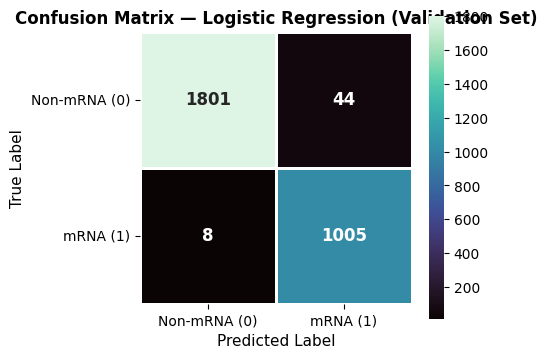

In [12]:
# Confusion matrix heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# compute confusion matrix
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])

# create heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="mako",
    linewidths=1,
    cbar=True,
    square=True,
    annot_kws={"size": 12, "weight": "bold"}
)

plt.title("Confusion Matrix — Logistic Regression (Validation Set)", fontsize=12, weight="bold")
plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)
plt.xticks([0.5, 1.5], ["Non-mRNA (0)", "mRNA (1)"])
plt.yticks([0.5, 1.5], ["Non-mRNA (0)", "mRNA (1)"], rotation=0)
plt.tight_layout()
plt.show()

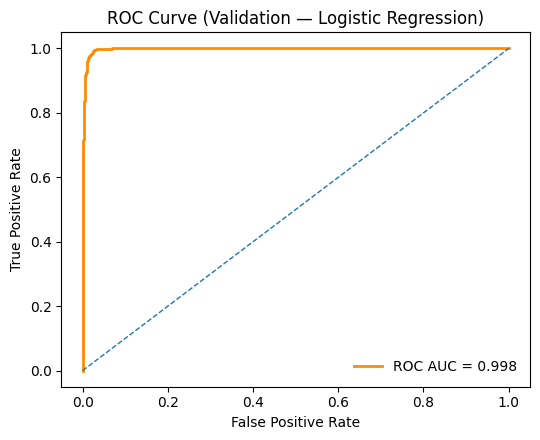

In [13]:
# ROC curve
fpr, tpr, _ = roc_curve(y_val, val_prob)
rocA = sk_auc(fpr, tpr)
plt.figure(figsize=(5.5, 4.5))
plt.plot(fpr, tpr, color="darkorange", linewidth=2, label=f"ROC AUC = {rocA:.3f}")
plt.plot([0,1], [0,1], "--", linewidth=1)
plt.title("ROC Curve (Validation — Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

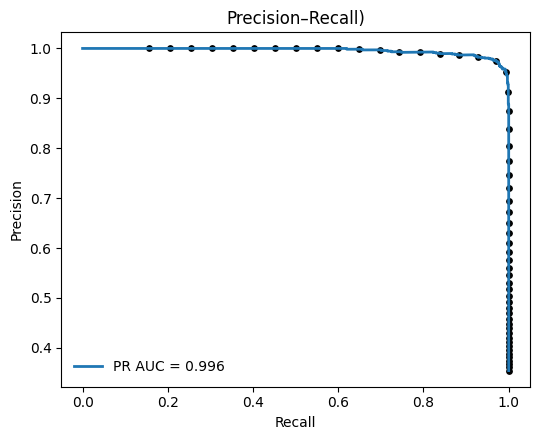

In [14]:
# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_val, val_prob)
prA = sk_auc(rec, prec)
plt.figure(figsize=(5.5, 4.5))
plt.plot(rec, prec, linewidth=2, label=f"PR AUC = {prA:.3f}")
plt.scatter(rec[::50], prec[::50], color="black", s=15)
plt.title("Precision–Recall)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(loc="lower left", frameon=False)
plt.tight_layout()
plt.show()

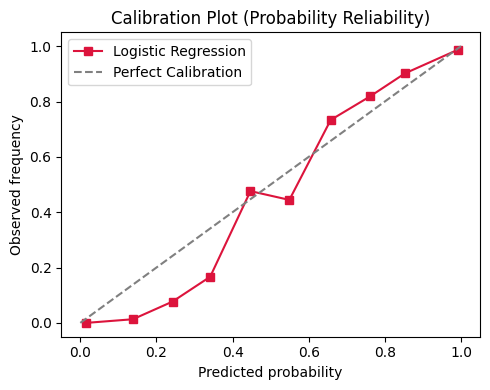

In [15]:
# Calibration curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, val_prob, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, "s-", color="crimson", label="Logistic Regression")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect Calibration")
plt.title("Calibration Plot (Probability Reliability)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
import joblib

# Save trained logistic regression model
joblib.dump(lr_pipe, "logistic_regression_model.pkl")


['logistic_regression_model.pkl']

In [18]:
from google.colab import files
files.download("logistic_regression_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>